In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jacobian
from getdist import MCSamples, plots

from tqdm import tqdm

import sys
sys.path.append("../")

from pldflow import plflow

import os
import jax
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Fresnel(plflow.PicardLefschetzModelBaseClass):
    ndim = 1
    def action_s(self, z, y, p=1):
        # return 1j*jnp.dot(z-y,z-y)# + p*1j/(1+jnp.dot(z,z))
        return 1j*jnp.dot(z, z) - 2j*jnp.dot(z, y)

## 1D

In [4]:
fresnel = Fresnel()

In [5]:
x = jnp.linspace(-3, 3, 400).reshape(-1, 1)
z = x.astype(jnp.complex64)
s = fresnel.vaction_s(z, 0, 1)
i = fresnel.vintegrand(z, 0, 1)

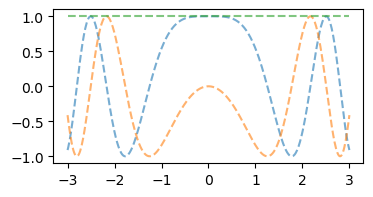

In [6]:
plt.figure(figsize=(4,2))
plt.plot(x, jnp.real(i), ls='--', alpha=0.6)
plt.plot(x, jnp.imag(i), ls='--', alpha=0.6)
plt.plot(x, jnp.abs(i) , ls='--', alpha=0.6)
plt.show()

In [7]:
t = jnp.linspace(0, 0.5, 5)
y = jnp.array([0.0])
p = jnp.array(1.0)
zt = fresnel.flow(x[0], t, y, p=p)

In [8]:
t = jnp.linspace(0, 0.5, 5)
y = jnp.array([0.0])
p = jnp.array(1.0)
%time zt = fresnel.vflow(x, t, y, p=p)
%time zt = fresnel.vflow(x, 5.0, y, p=p)

CPU times: user 223 ms, sys: 10.1 ms, total: 233 ms
Wall time: 236 ms
CPU times: user 506 ms, sys: 17.2 ms, total: 523 ms
Wall time: 530 ms


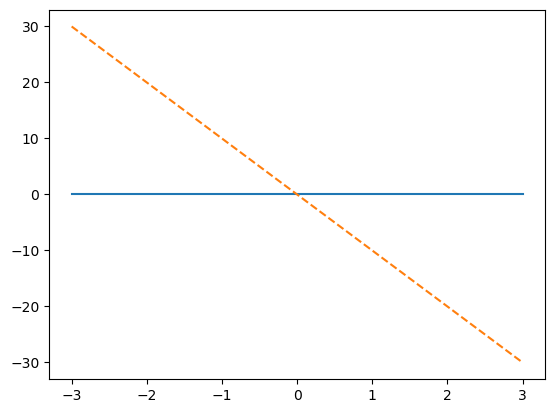

In [9]:
plt.plot(z.real, z.imag)
plt.plot(zt.real, zt.imag, ls='--')
plt.show()

In [10]:
t = jnp.linspace(0, 0.5, 5)
y = jnp.array([0.0])
p = jnp.array(1.0)
%time zt = fresnel.vflow(x, t, y, p=p)

CPU times: user 125 ms, sys: 7.46 ms, total: 133 ms
Wall time: 140 ms


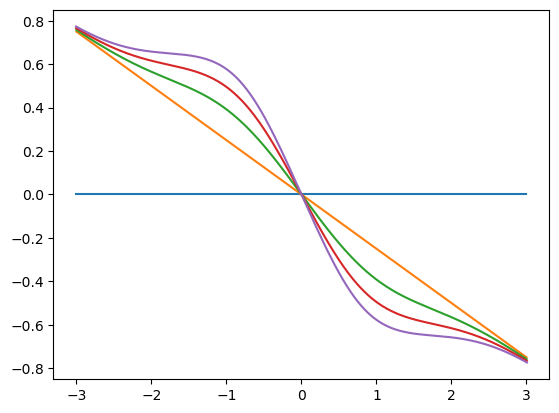

In [11]:
plt.plot(zt[:,:,0].real, zt[:,:,0].imag)
plt.show()

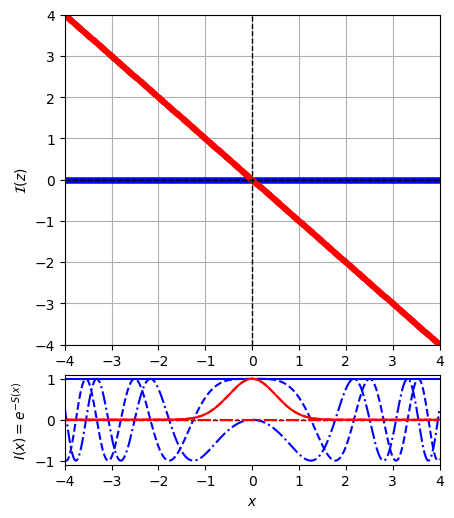

In [12]:
x = jnp.linspace(-4,4,1000).reshape(-1,1)
t = jnp.linspace(0, 0.5, 2)

fig, axes = fresnel.plot1d(x, t, y, p=p)

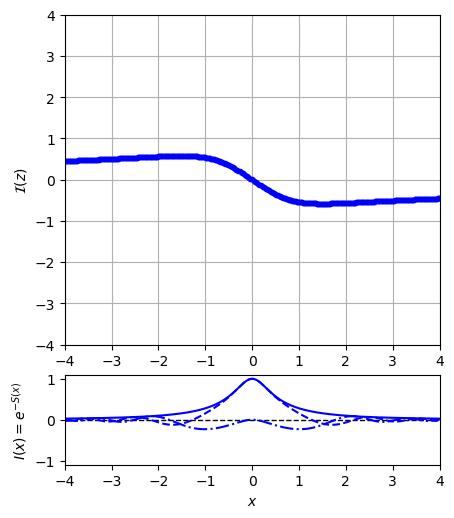

In [13]:
x = jnp.linspace(-4,4,500).reshape(-1, 1)
t = jnp.linspace(0, 0.5, 20)
fresnel.plot1dgif("fresnel.gif", x,t,y,p=p)

In [14]:
y = jnp.array([0.0])
p = jnp.array(1)
%time z = fresnel.flow(x[0], 0.1, y, p=p)
%time j = fresnel.flow_jacobian(x[0], 0.1, y, p=p)

CPU times: user 232 ms, sys: 11.2 ms, total: 243 ms
Wall time: 250 ms
CPU times: user 1.63 s, sys: 64.3 ms, total: 1.69 s
Wall time: 1.74 s


In [15]:
%time z = fresnel.vflow(x, 0.1, y, p=p)
%time j = fresnel.vflow_jacobian(x, 0.1, y, p=p)

CPU times: user 211 ms, sys: 9.8 ms, total: 221 ms
Wall time: 220 ms
CPU times: user 734 ms, sys: 33 ms, total: 767 ms
Wall time: 772 ms


In [16]:
t = jnp.linspace(0, 1.0, 100)
%time z = fresnel.vflow(x, t, y, p=p)
%time j = fresnel.vflow_jacobian(x, t, y, p=p)

CPU times: user 360 ms, sys: 12.1 ms, total: 372 ms
Wall time: 379 ms
CPU times: user 1.66 s, sys: 77.3 ms, total: 1.73 s
Wall time: 1.82 s


sampling

In [17]:
priors = {'x':(-7,7,1), 'y':(-5,5,1)}
sampler = plflow.HMCSampler(fresnel, priors)

In [18]:
# t = jnp.linspace(0, 0.5, 20)
t = jnp.linspace(0, 0.4, 100)
sampler.sample(num_samples=10000, t=t)

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
  0%|          | 0/10500 [00:00<?, ?it/s]/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [00:07<00:00, 1406.82it/s, 3 steps of size 1.46e-01. acc. prob=0.88] 


In [19]:
s = sampler.get_samples(jnp.array)

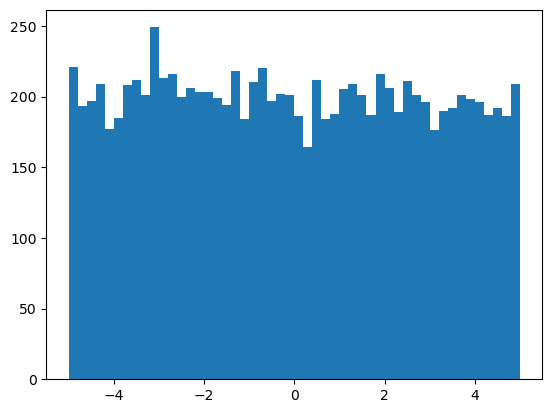

In [20]:
plt.hist(s[:,1], bins=50)
plt.show()

In [21]:
mcs = sampler.get_samples(format=MCSamples)

Removed no burn in


<Figure size 400x400 with 0 Axes>

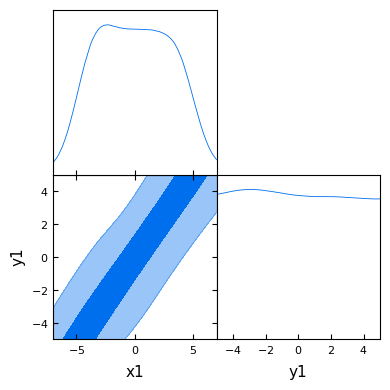

In [22]:
g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1'], filled=True)
plt.show()

normalizing flow

In [23]:
maf = plflow.MAFModel(sampler)

In [56]:
maf.build(hidden_dims=[128,128], n_transforms=8)

In [57]:
%time maf.train(n_steps=1_000, batch_size=128)

Training MAF: 100%|██████████| 1000/1000 [00:24<00:00, 40.67it/s]


CPU times: user 23.5 s, sys: 4.47 s, total: 27.9 s
Wall time: 24.8 s


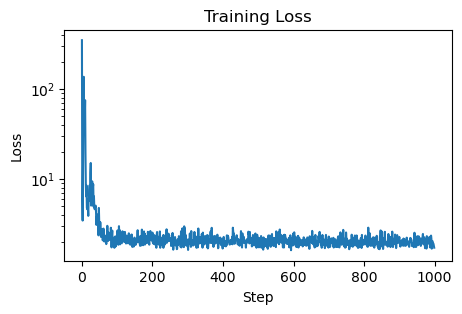

In [58]:
maf.plot_loss()

In [59]:
y = jnp.array(4.0)
%time x = maf.sample(y, num_samples=10000, seed=5)
%time lnp = maf.log_prob(x, y)

CPU times: user 249 ms, sys: 28 ms, total: 277 ms
Wall time: 198 ms
CPU times: user 246 ms, sys: 15.4 ms, total: 262 ms
Wall time: 184 ms


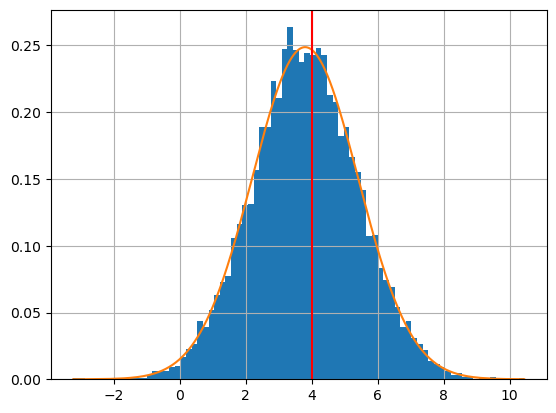

In [60]:
a = jnp.argsort(x.ravel())
plt.hist(x.ravel(), bins=80, density=True)
plt.plot(x[a], jnp.exp(lnp[a]))
plt.axvline(y, color='r')
plt.grid()
plt.show()

In [61]:
t = jnp.linspace(0, 1.0, 20)
y = jnp.array([4.0])
x = maf.sample(y, num_samples=1000, seed=0, beta=2.0)
lnp = maf.log_prob(x, y)
%time Z = fresnel.integrate(x, lnp, t, y=y)

CPU times: user 430 ms, sys: 9.86 ms, total: 439 ms
Wall time: 439 ms


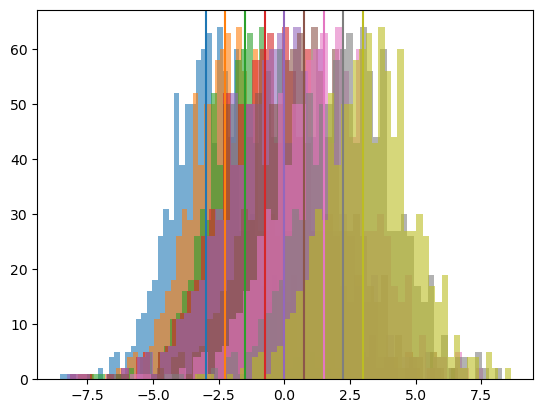

In [62]:
y = jnp.linspace(-3, 3, 9)
for i, _y in enumerate(y):
    x = maf.sample(_y, num_samples=1000, seed=0)
    color = f"C{i}"
    plt.hist(x.ravel(), bins=50, density=False, alpha=0.6, color=color)
    plt.axvline(_y, color=color)
plt.show()

In [63]:
# t = jnp.linspace(0, 0.5, 20)
t = jnp.linspace(0, 0.4, 100)
y = jnp.linspace(-3, 3, 100)

Z = []
for _y in tqdm(y):
    _y = jnp.array([_y])
    x = maf.sample(_y, num_samples=1000, seed=0, beta=1.0)
    lnp = maf.log_prob(x, _y, beta=1.0)
    _Z = fresnel.integrate(x, lnp, t, y=_y)
    Z.append(_Z)
Z = jnp.array(Z)

100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


In [64]:
ndim = fresnel.ndim
Z_ana = jnp.exp(1j*y**2) * ((1-1j)*jnp.sqrt(jnp.pi/2.0))**ndim

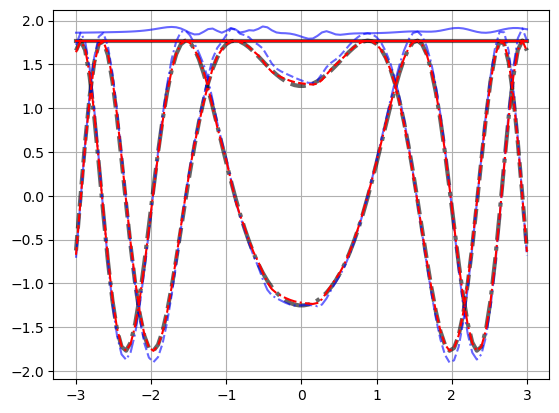

In [65]:
# analytic
plt.plot(y, jnp.real(Z_ana), color='k', ls='--', alpha=0.6, lw=3)
plt.plot(y, jnp.imag(Z_ana), color='k', ls='-.', alpha=0.6, lw=3)
plt.plot(y, jnp.abs(Z_ana) , color='k', ls='-' , alpha=0.6, lw=3)
# estimate
plt.plot(y, jnp.real(Z), color='b', ls='--', alpha=0.6)
plt.plot(y, jnp.imag(Z), color='b', ls='-.', alpha=0.6)
plt.plot(y, jnp.abs(Z) , color='b', ls='-' , alpha=0.6)
# abs corrected
norm = jnp.abs(Z)/jnp.abs(Z_ana)
plt.plot(y, jnp.real(Z)/norm, color='r', ls='--')
plt.plot(y, jnp.imag(Z)/norm, color='r', ls='-.')
plt.plot(y, jnp.abs(Z) /norm, color='r', ls='-')
plt.grid()
plt.show()

In [48]:
y = jnp.array([1.0])
x = maf.sample(y, num_samples=1000, seed=0, beta=2.0)
lnp = maf.log_prob(x, y)
z = fresnel.vflow(x, t, uselast=True, y=y)
ix = fresnel.vintegrand(x, y)
iz = fresnel.vintegrand(z, y)
j  = fresnel.vflow_jacobian(x, t, y=y, uselast=True)
print(jnp.mean(iz*j*jnp.exp(-lnp)))

(2.381122-1.8726283j)


/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


4.3710046


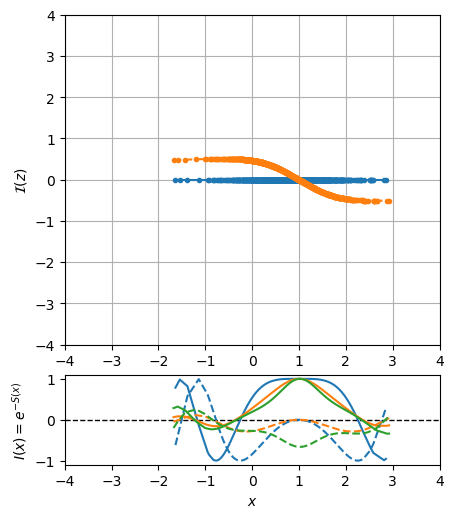

In [55]:
fig, axes = fresnel._plot1d_template()
a = jnp.argsort(x.ravel())
axes[0].plot(x[a,0].real, x[a,0].imag, ls='-', marker='.')
axes[0].plot(z[a,0].real, z[a,0].imag, ls='--', marker='.')
axes[0].set_xlim(-4,4)
axes[0].set_ylim(-4,4)
axes[1].plot(x[a,0], ix[a].real, 'C0')
axes[1].plot(x[a,0], ix[a].imag, 'C0--')
axes[1].plot(z[a,0], iz[a].real, 'C1-')
axes[1].plot(z[a,0], iz[a].imag, 'C1--')
pp = iz*j*jnp.exp(-lnp)
pm = pp.real.max()
print(pm)
axes[1].plot(z[a,0], (pp/pm)[a].real, 'C2-')
axes[1].plot(z[a,0], (pp/pm)[a].imag, 'C2--')
plt.show()

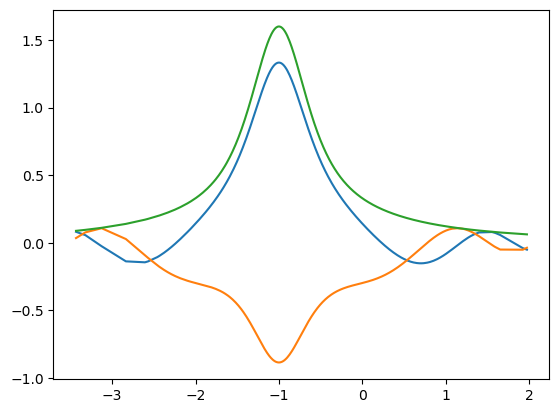

(0.51843625-0.43932295j)
(0.51843625-0.43932295j)
(0.51843625-0.43932295j)


In [39]:
ii = iz*j #* jnp.exp(-lnp)
plt.plot(x[a,0], ii[a].real, 'C0')
plt.plot(x[a,0], ii[a].imag, 'C1')
plt.plot(x[a,0], jnp.abs(ii[a]), 'C2')
# plt.plot(x[a,0], jnp.abs(j[a]), 'C2')
# plt.plot(x[a,0][lnp > jnp.log(1e-2)], ii[a][lnp > jnp.log(1e-2)].real, 'red', ls='--', marker='.')
plt.show()

print(jnp.mean(ii))
print(jnp.mean(ii[lnp>jnp.log(1e-2)]))
print(jnp.mean(ii[lnp>jnp.log(1e-3)]))


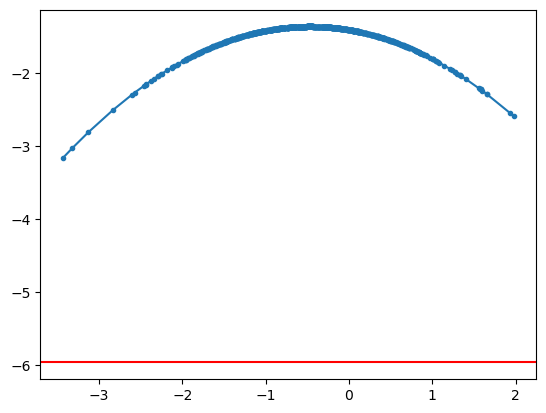

In [43]:
plt.plot(x[a,0], lnp[a], marker='.')
plt.axhline(lnp.max()+jnp.log(1e-2), color='r')
plt.show()